[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scryptan/python_hw/blob/master/First_hw_python.ipynb)

In [ ]:
!pip install grequests
!pip install requests
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [2]:
import seaborn as sns
import grequests
import requests

from datetime import datetime
from IPython.display import clear_output

import pandas as pd
import matplotlib.pyplot as plt

import os
import os.path
import json
import warnings
warnings.simplefilter("ignore", category=UserWarning)

# Собираем список id всех объектов

In [ ]:
start = datetime.now()

offset_ = 1
limit_ = 100
a_urls = []

for i in range(110): # 110 - волшебное число, да не хорошо, но если делать нормально через вычитывание всего, то очень долго проверять, а так методом тыка стало известно, что там меньше 11к записей
    a_urls.append(f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={offset_ * i * limit_}&limit={limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0')
    
async_list = []

rs = [grequests.get(u) for u in a_urls]
objids = []
for res in grequests.imap(rs, size=16):
    if not res.ok:
        continue
        
    objects_data = res.json()
    objects_list = objects_data.get('data').get('list')
    if not objects_list:
        continue
    
    clear_output()
    objids.extend(x.get('objId') for x in objects_list)
    print(len(objids))

print(len(objids))
print(datetime.now() - start)

# Собираем все возможные объекты по полученным прежде id

In [ ]:
start = datetime.now()
full_objects = []


a_fullObj_urls = []
for objId in objids:
    a_fullObj_urls.append(f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{objId}')

rs_objects = [grequests.get(u) for u in a_fullObj_urls]

for res in grequests.imap(rs_objects, size=16):
    if not res.ok:
        continue
        
    object_data = res.json()
    full_obj = object_data.get('data')

    if not full_obj:
        continue
    
    clear_output()
    full_objects.append(full_obj)
    print()
    print(f'{len(full_objects)}/{len(objids)}')

print(len(full_objects))
print(datetime.now() - start)

In [3]:
full_objects = []
out_filename = "./output/output.pkl.gz"

download_from_github = True

if download_from_github:
    df = pd.read_csv('https://raw.githubusercontent.com/scryptan/python_hw/master/output/output.csv')
elif full_objects:
    df = pd.json_normalize(full_objects)
elif os.path.exists(out_filename):
    df = pd.read_csv(out_filename)
    full_objects = json.loads(df.to_json(orient="split"))
else:
    raise Exception('Empty objects')

if not os.path.exists(out_filename):
    os.makedirs(os.path.dirname(out_filename), exist_ok=True)
    df.to_csv(out_filename)  
    
regions = requests.get('https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/dictionary/regions').json()
regions_dict = dict((region['id'], region['name']) for region in regions)

df.head()
df.shape

(10587, 109)

In [ ]:
def first(iterable, default = None, condition = lambda x: True):
    try:
        return next(x for x in iterable if condition(x))
    except StopIteration:
        if default is not None and condition(default):
            return default
        else:
            raise

In [ ]:
df.head()

In [ ]:
df_with_name_obj = df.dropna(subset=['nameObj'])
pd.set_option('display.max_columns', None)
df_with_name_obj["objPriceAvg"]

#  Рассчитать средние цены за квадратный метр по регионам.

<AxesSubplot: xlabel='costs', ylabel='regions'>

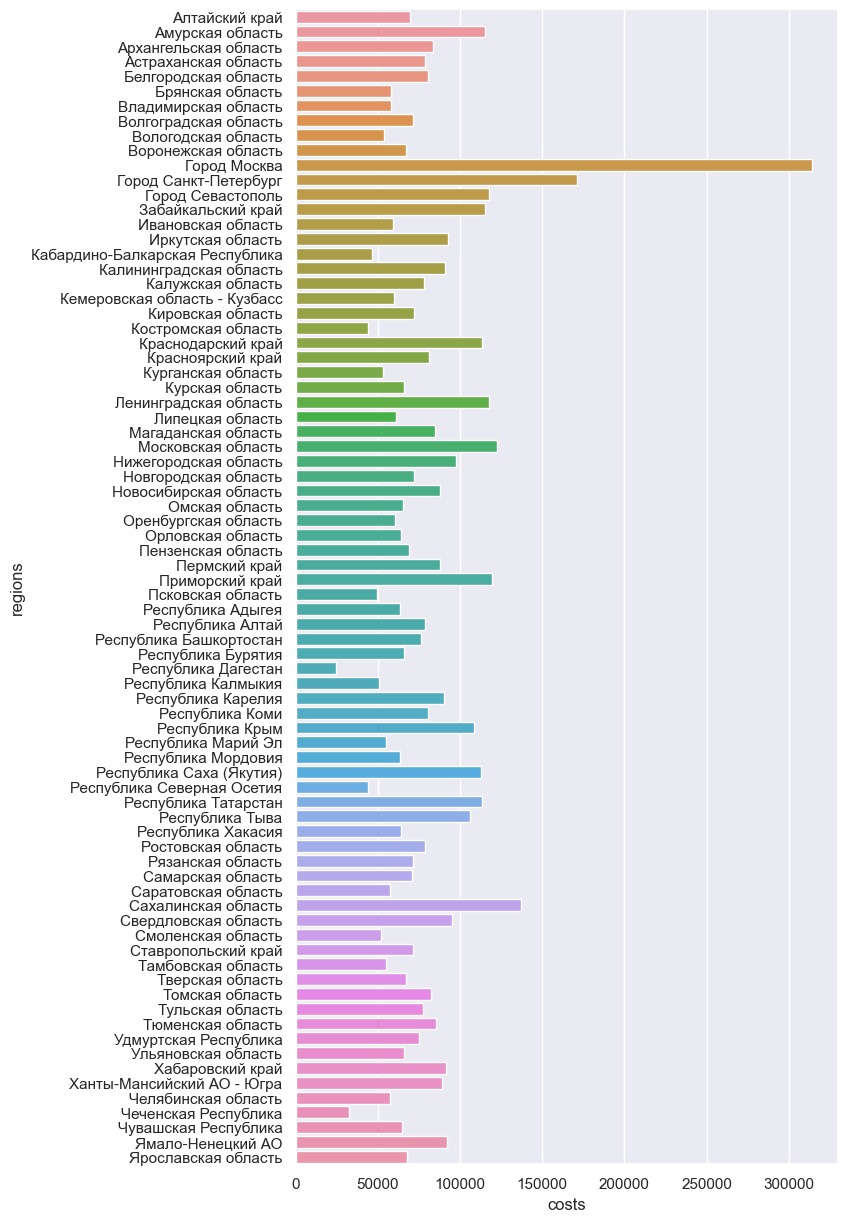

In [33]:
df_for_price = df.dropna(subset=['objPriceAvg'])
pd.set_option('display.max_columns', None)
mean_prices_by_region = df_for_price.replace({"region": regions_dict}).groupby(['region'])['objPriceAvg'].mean()

sns.set_theme()

prices_df = mean_prices_by_region.reset_index()
prices_df.columns = ['regions', 'costs']

sns.set(rc = {'figure.figsize':(7,15)})
sns.barplot(y = 'regions', x = 'costs', data = prices_df, errorbar=None)

Исходя из графика выше получается, что в МСК самая большая цена за квадратный метр, самая низкая в дагестане, большинство остальных менее 150000

# Вводимые по региону и году

<AxesSubplot: xlabel='amount', ylabel='region'>

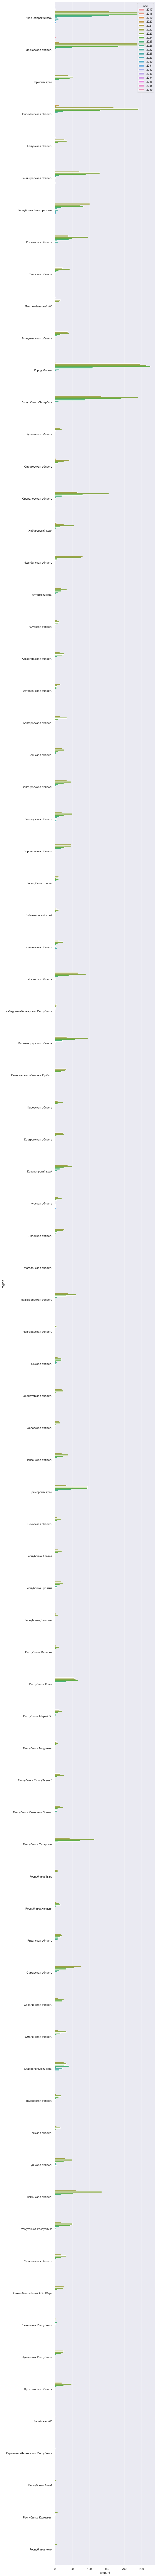

In [55]:
df_region_year = df.replace({"region": regions_dict})

df_region_year['objReady100PercDt'] = pd.to_datetime(df_region_year['objReady100PercDt']).dt.year
df_region_year = df_region_year.rename(columns={'objReady100PercDt':'year', 'id':'amount'})

pd.set_option('display.max_rows', 15)
sns.set(rc = {'figure.figsize':(7,180)})
# region_year_groups = df_region_year.groupby(['year', 'region']).count()['amount'].unstack().plot.bar(legend=True)
df_res = df_region_year.groupby(['year', 'region']).count().reset_index()
# df_res
sns.barplot(x = 'amount', y = 'region', hue='year', data = df_res, errorbar=None)

Из графика выше стало ясно, что большинство квартир будут сданы в районе 24 +- 2 года, так же большинство объектов будет сдано в москве, московской области, краснодарским краем, новосибирской областью и т.д

# Сравнить этажность домов, количество квартир, жилую площадь, количество парковочных мест и цену за квадратный метр в разных регионах

<AxesSubplot: xlabel='objFlatCnt', ylabel='region'>

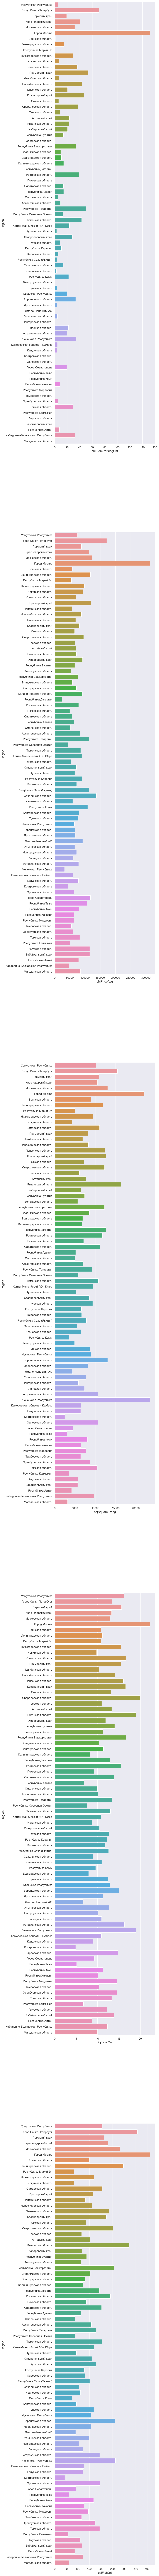

In [56]:
df_region = df.replace({"region": regions_dict})
df_region = df_region.dropna(subset=['objPriceAvg','objSquareLiving','objFloorCnt','objFlatCnt'])
df_region = df_region[['region', 'objPriceAvg','objSquareLiving','objFloorCnt','objFlatCnt', 'objElemParkingCnt']]

fig, axs = plt.subplots(nrows=5)

sns.set(rc = {'figure.figsize':(7,180)})
sns.barplot(y = 'region', x = 'objElemParkingCnt', data = df_region, ax = axs[0], errorbar=None)
sns.barplot(y = 'region', x = 'objPriceAvg', data = df_region, ax = axs[1], errorbar=None)
sns.barplot(y = 'region', x = 'objSquareLiving', data = df_region, ax = axs[2], errorbar=None)
sns.barplot(y = 'region', x = 'objFloorCnt', data = df_region, ax = axs[3], errorbar=None)
sns.barplot(y = 'region', x = 'objFlatCnt', data = df_region, ax = axs[4], errorbar=None)

# objPriceAvg - цена за квадратный метр
# objSquareLiving - жилая площадь
# objFloorCnt - количество этажей
# objFlatCnt - количество квартир
# objElemParkingCnt - количество парковочных мест

Наибольшее количество парковок в москве, так же примерно в 20% регионов будут сданы объекты без парковочных мест
Наибольшие цены за квадратный метр в москве, спб, сахалинской области, наименьшие в дагестане, в остальном не привышают 150000
Наибольшая жилая площадь в чеченской республике, москве и рязанской республике, в остальном не превышают 15000
Наиболее высокие здания будут сданы в москве - 23 этаже, наименее высокие в костроме, до 5 этажей
Наибольшее количество квартир в москве, спб, рязанской области

# Скачать фотку

In [ ]:
def download_photo(): # сделал скачивание картинки с конкретного объекта, можно заменить на цикл и всё будет работать, но с 11к объектов качать картинки такое себе
    id = full_objects[0].get('id')
    photo_obj = full_objects[0].get('photoRenderDTO')
    
    if not photo_obj: # значит картинки нет
        return
    
    link = photo_obj[0].get('objRenderPhotoUrl') # так же качаю первую картинку, тоже можно заменить на цикл, если сильно захотеть
    resp = requests.get(link).content
    filename = f'./output/images/{id}.jpg' 
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'wb') as f:
        f.write(resp)
    plt.imshow(plt.imread(filename))

download_photo()